In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

C:\Users\shubhamkumar.singh\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X_train, Y_train, _ = load_data('data')
X_test, Y_test, _ = load_data('data')
print(Y_train[0])

(367, 227, 227, 3)
here2:  (2, 367)
shape of input data:  (367, 227, 227, 3)
shape of target variable:  (367, 2)
(367, 227, 227, 3)
here2:  (2, 367)
shape of input data:  (367, 227, 227, 3)
shape of target variable:  (367, 2)
[1. 0.]


In [3]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, 227, 227, 3])
    Y = tf.placeholder(tf.float32,[None, 2])
    
    return X, Y

In [4]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [11,11,3,96], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [5,5,96,256], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3", [3,3,256,384], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W4 = tf.get_variable("W4", [3,3,384,384], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W5 = tf.get_variable("W5", [3,3,384,256], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {"W1":W1,
                 "W2":W2,
                 "W3":W3,
                 "W4":W4,
                 "W5":W5,
                 "bc1": tf.Variable(tf.constant(0.0, shape=[96]),        name="bc1"),
                 "bc2": tf.Variable(tf.constant(1.0, shape=[256]),       name="bc2"),
                 "bc3": tf.Variable(tf.constant(0.0, shape=[384]),       name="bc3"),
                 "bc4": tf.Variable(tf.constant(1.0, shape=[384]),       name="bc4"),
                 "bc5": tf.Variable(tf.constant(1.0, shape=[256]),       name="bc5"),
                 "bf1": tf.Variable(tf.constant(1.0, shape=[120]),       name="bf1"),
                 "bf2": tf.Variable(tf.constant(1.0, shape=[84]),        name="bf2"),
                 "bf3": tf.Variable(tf.constant(1.0, shape=[2]),         name="bf3")}

    return parameters
    

In [5]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    W5 = parameters['W5']
    bc1 = parameters['bc1']
    bc2 = parameters['bc2']
    bc3 = parameters['bc3']
    bc4 = parameters['bc4']
    bc5 = parameters['bc5']
    bf1 = parameters['bf1']
    bf2 = parameters['bf2']
    bf3 = parameters['bf3']
    
    #layer1
    X1 = tf.nn.conv2d(X, W1, strides = [1,4,4,1], padding ='SAME')
    Z1 = tf.nn.bias_add(X1, bc1)
    A1 = tf.nn.relu(Z1)
    L1 = tf.nn.local_response_normalization(A1, depth_radius=5.0, bias=2.0, alpha=1e-4, beta=0.75)
    P1 = tf.nn.max_pool(L1, ksize=[1,3,3,1],strides=[1,2,2,1], padding='VALID')
    #layer2
    X2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding ='SAME')
    Z2 = tf.nn.bias_add(X2, bc2)
    A2 = tf.nn.relu(Z2)
    L2 = tf.nn.local_response_normalization(A2, depth_radius=5.0, bias=2.0, alpha=1e-4, beta=0.75)
    P2 = tf.nn.max_pool(L2, ksize=[1,3,3,1],strides=[1,2,2,1], padding='VALID')
    #layer3
    X3 = tf.nn.conv2d(P2, W3, strides = [1,1,1,1], padding ='SAME')
    Z3 = tf.nn.bias_add(X3, bc3)
    P3 = tf.nn.relu(Z3)
    #A3 = tf.nn.local_response_normalization(A3, depth_radius=5.0, bias=2.0, alpha=1e-4, beta=0.75)
    
    #layer4
    X4 = tf.nn.conv2d(P3, W4, strides = [1,1,1,1], padding ='SAME')
    Z4 = tf.nn.bias_add(X4, bc4)
    P4 = tf.nn.relu(Z4)

    #layer5
    X5 = tf.nn.conv2d(P4, W5, strides = [1,1,1,1], padding ='SAME')
    Z5 = tf.nn.bias_add(X5, bc5)
    A5 = tf.nn.relu(Z5)
    P5 = tf.nn.max_pool(A5, ksize=[1,3,3,1],strides=[1,2,2,1], padding='VALID')
    
    P = tf.contrib.layers.flatten(P5)
    #fully_connected_1
    #Z3 = tf.contrib.layers.fully_connected(P,400,activation=tf.nn.relu) 
    fc1_w = tf.Variable(tf.truncated_normal(shape = (9216,120), mean = 0, stddev = 0.1))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(P,fc1_w) + fc1_b
    Z6 = tf.nn.relu(fc1)
    #fully_connected_2
    fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = 0, stddev = 0.1))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(Z6,fc2_w) + fc2_b
    Z7 = tf.nn.relu(fc2)
    #fully_connected_3
    fc3_w = tf.Variable(tf.truncated_normal(shape = (84,2), mean = 0 , stddev = 0.1))
    fc3_b = tf.Variable(tf.zeros(2))
    Z8 = tf.matmul(Z7, fc3_w) + fc3_b
    
    return Z8

In [6]:
def compute_cost(Z8, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z8, labels=Y))
    
    return cost

In [7]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.0009,
         num_epochs=32, minibatch_size=32,print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed=3
    (m,n_H0,n_W0,n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    print("n_y: ", n_y)
    costs=[]
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    
    Z8 = forward_propagation(X, parameters)
    cost = compute_cost(Z8, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            #print("after epoch")
            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z8, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

n_y:  2
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 7.540435
Cost after epoch 1: 0.940698
Cost after epoch 2: 0.774032
Cost after epoch 3: 0.766147
Cost after epoch 4: 0.749192
Cost after epoch 5: 0.748594
Cost after epoch 6: 0.741769
Cost after epoch 7: 0.843266
Cost after epoch 8: 0.756913
Cost after epoch 9: 0.695969
Cost after epoch 10: 0.685627
Cost after epoch 11: 0.572467
Cost after epoch 12: 0.502982
Cost after epoch 13: 0.387738
Cost after epoch 14: 0.328291
Cost after epoch 15: 0.390248
Cost after epoch 16: 0.197913
Cost after epoch 17: 0.200133
Cost after epoch 18: 0.126696
Cost after epoch 19: 0.128145
Cost after epoch 20: 0.156374
Cost after epoch 21: 0.204965
Cost after epoch 22: 0.101577
Cost after epoch 23: 0.053340
Cost after epoch 24: 0.073667
Cost after epoch 25: 0.079312
Cost after epoch 26: 0.087673


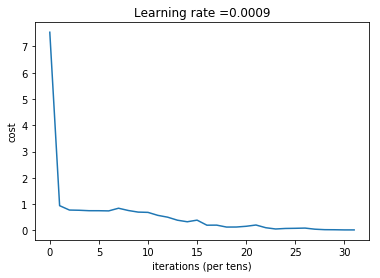

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9945504
Test Accuracy: 0.9945504


In [8]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

In [9]:
print(X_train[0].shape)

(227, 227, 3)
